In [1]:
pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162998 sha256=880fb4f2353fec64af30ce4df46f95c20d8b32f3a7eb76614057712564905d7f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

In [31]:
# Load datasets
links_df = pd.read_csv('links.csv')
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
tags_df = pd.read_csv('tags.csv')


In [32]:
# Merge movies with ratings
movie_ratings_df = pd.merge(movies_df, ratings_df, on='movieId')

# Define the Reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the Surprise dataset
data = Dataset.load_from_df(movie_ratings_df[['userId', 'movieId', 'rating']], reader)

# Split the dataset into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the SVD algorithm on the trainset
algo_svd = SVD()
algo_svd.fit(trainset)

# Make predictions on the testset using SVD
predictions_svd = algo_svd.test(testset)

In [33]:

# Merge movies with tags
movie_tags_df = pd.merge(movies_df, tags_df, on='movieId', how='left')

# Combine tags for each movie
movie_tags_df['combined_tags'] = movie_tags_df.groupby('movieId')['tag'].transform(lambda x: ' '.join(x.fillna('')))

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform TF-IDF vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_tags_df['combined_tags'])

# Calculate cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create a dictionary to store the ground truth ratings for each user
true_ratings = defaultdict(list)
for userId, movieId, true_rating in testset:
    true_ratings[userId].append((movieId, true_rating))


In [35]:
# Hybrid recommendation: combine SVD and content-based recommendations
hybrid_recommendations = {}

for userId in true_ratings:
    # Get top-k recommendations for the user from SVD
    user_top_k_svd = [pred.iid for pred in sorted(predictions_svd, key=lambda x: x.est, reverse=True)[:k]]

    # Get top-k recommendations for the user based on cosine similarity
    user_sim_scores = cosine_sim[userId]
    user_top_k_cb = [movie_tags_df.iloc[i]['movieId'] for i, score in sorted(enumerate(user_sim_scores), key=lambda x: x[1], reverse=True)[:k_cb]]

    # Combine recommendations from both methods
    hybrid_recommendations[userId] = set(user_top_k_svd + user_top_k_cb)


Hybrid Precision: 0.06091954022988527
Hybrid Recall: 0.03352261323532026


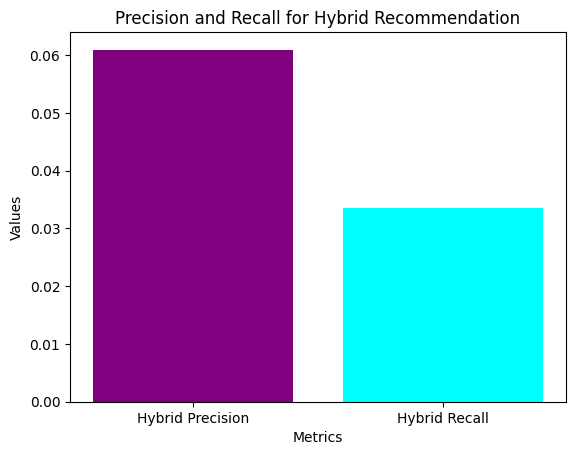

In [36]:
# Calculate precision and recall for hybrid recommendations
precision_sum_hybrid = 0
recall_sum_hybrid = 0
for userId in true_ratings:
    relevant_items_hybrid = sum(1 for (movieId, _) in true_ratings[userId] if movieId in hybrid_recommendations[userId])
    precision_sum_hybrid += relevant_items_hybrid / k
    recall_sum_hybrid += relevant_items_hybrid / len(true_ratings[userId])

precision_hybrid = precision_sum_hybrid / len(true_ratings)
recall_hybrid = recall_sum_hybrid / len(true_ratings)

print("Hybrid Precision:", precision_hybrid)
print("Hybrid Recall:", recall_hybrid)

# Plot bar graph for precision and recall of the hybrid recommendation
labels = ['Hybrid Precision', 'Hybrid Recall']
values = [precision_hybrid, recall_hybrid]

plt.bar(labels, values, color=['purple', 'cyan'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Precision and Recall for Hybrid Recommendation')
plt.show()